In [1]:
import torch
import torchvision
#I havent sanitized the imports, it is a but much now. But whatever...
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.datasets import VisionDataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#in models/ there are quite a few models, saved in the intermediate training steps. 
#following: ssdlite_cows_model_exxx.pth hwere xxx is n epoch
# the latest is: models/ssdlite_cows_model_500e.pth (note the switched e)
from IPython.core.debugger import set_trace

# loss on val-set hovered around the 0.01 range from epoch 200 onward
# (which I think was calculated with cross-entropy and class accuracy afaik (but only 1 class: cows, with label: 0)
# Create your SSD Lite model without any pretrained weights:

model = ssdlite320_mobilenet_v3_large(weights= "SSDLite320_MobileNet_V3_Large_Weights.DEFAULT")
# but then like overwrite it with the local state_dict etc.
model.load_state_dict(torch.load("models/ssdlite_cows_model_v2_500e.pth"))
model = model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, boxes, transform=None):
        self.images = images
        self.labels = labels
        self.boxes = boxes
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.int8)
        boxes = torch.tensor(self.boxes[idx], dtype = torch.float32)
        target = {'boxes': boxes,
                 'labels': labels}
        
        if self.transform:
            image = self.transform(image)

        return image, target

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Create the dataset
test_dataset = torch.load("data/test_set.pkl")
train_dataset = torch.load("data/train_set.pkl")

# Create a DataLoader for the VOC dataset

test_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn = collate_fn)

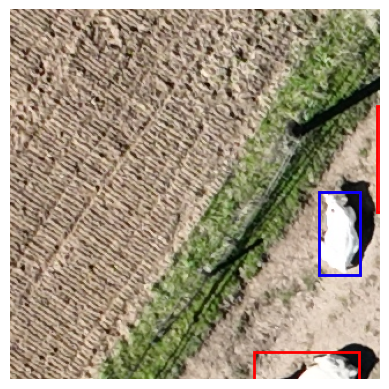

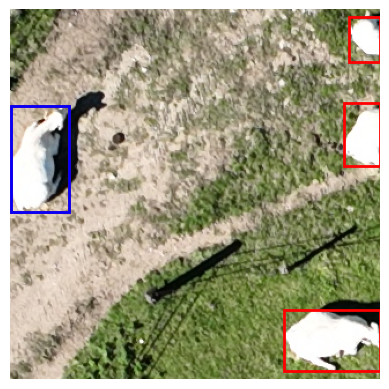

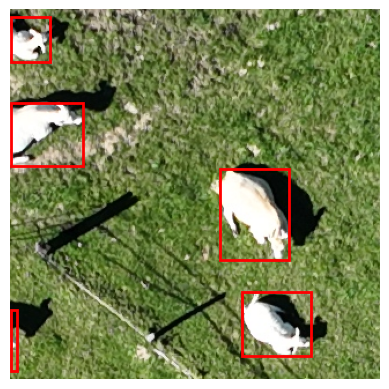

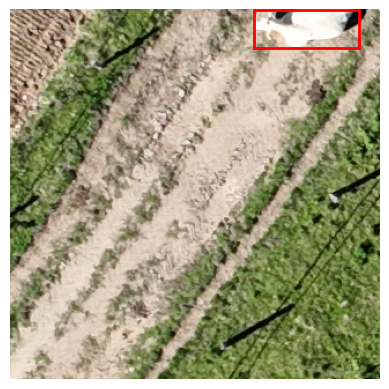

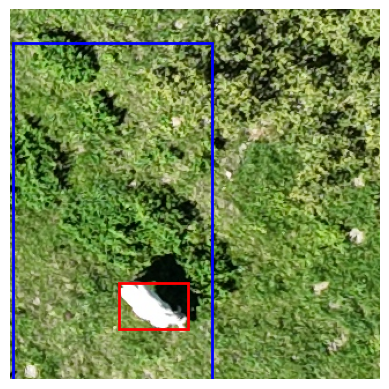

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

n = 5
i = 0
data_iter = iter(test_loader)
while i < n:
    image, target = next(data_iter)
    fig, ax = plt.subplots(1)
    ax.imshow(np.transpose(image[0].numpy(), (1, 2, 0)) / 255.0)

    for box in target[0]["boxes"]:
        xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        rectangle = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rectangle)

    prediction = model(image)

    for box, score, label in zip(prediction[0]["boxes"], prediction[0]["scores"], prediction[0]["labels"]):
        box = box.detach().numpy()
        score = score.detach().numpy()
        label = label.detach().numpy()
        if score >= 0.1 and label == 1:
            xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
            rectangle = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rectangle)

    plt.axis('off')  # Turn off axis labels
    plt.show()
    i += 1

In [5]:
def calculate_iou(box1, box2):
    # Calculate IoU between two bounding boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersect_x = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    intersect_y = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    intersection = intersect_x * intersect_y
    union = w1 * h1 + w2 * h2 - intersection

    return intersection / union

# Define a function to calculate mAP
def calculate_performance(model, data_loader, iou_threshold=0.5):
    model.eval()
    model.to("cpu")

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    final_iou = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image for image in images]
            gt_boxes = [t["boxes"].detach().numpy() for t in targets][0]

            predictions = model(images)
            predictions = [{k: v.detach().numpy() for k, v in pred.items()} for pred in predictions]
            for box, score, label in zip(predictions[0]["boxes"], predictions[0]["scores"], predictions[0]["labels"]):
                if score >= 0.1 and label == 1:
                    match = False
                    iou_found = 0
                    for gt_box in gt_boxes:
                        iou = calculate_iou(box, gt_box)
                        if iou > iou_threshold:
                            iou_found = iou
                            match = True
                            
                    if match:
                        true_positives += 1
                    else:
                        false_positives += 1

                    final_iou.append(iou_found)
                    
            for gt_box in gt_boxes:
                match = False
                for box, score, label in zip(predictions[0]["boxes"], predictions[0]["scores"], predictions[0]["labels"]):
                    if score >= 0.1 and label == 1:
                        iou = calculate_iou(box, gt_box)
                        if iou > iou_threshold:
                            match = True
                            
                    if not match:
                        false_negatives += 1

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
                    
    return precision, recall

# Example usage
precision, recall = calculate_performance(model, test_loader)
print("Precision:", precision, "Recall:", recall)

Precision: 0.36016655100624567 Recall: 0.001084655365909219


In [6]:
##########################################################################################
####  Piecewise Linear Quantization (PWLQ)
##########################################################################################

def piecewise_linear_quant(w, bits=4.0, scale_bits=0.0, search_range=10):
    min_err = 10000
    abs_max = torch.max(torch.abs(w))
    
    ## first stage
    for bkp_ratio in np.arange(0.1, 1.0, 0.1):
        break_point = bkp_ratio * abs_max
        err, qw = pwlq_quant_error(w, bits, scale_bits, abs_max, break_point)
        if err < min_err:
            min_err = err
            best_ratio = bkp_ratio
            best_qw = qw

    ## second stage
    ratio_start, ratio_end = best_ratio - 0.01 * search_range, best_ratio + 0.01 * search_range
    for bkp_ratio in np.arange(ratio_start, ratio_end, 0.01):
        break_point = bkp_ratio * abs_max
        err, qw = pwlq_quant_error(w, bits, scale_bits, abs_max, break_point)
        if err < min_err:
            min_err = err
            best_ratio = bkp_ratio
            best_qw = qw

    ## third stage
    ratio_start, ratio_end = best_ratio - 0.001 * search_range, best_ratio + 0.001 * search_range
    for bkp_ratio in np.arange(ratio_start, ratio_end, 0.001):
        break_point = bkp_ratio * abs_max
        err, qw = pwlq_quant_error(w, bits, scale_bits, abs_max, break_point)
        if err < min_err:
            min_err = err
            best_ratio = bkp_ratio
            best_qw = qw
        
    return best_qw, best_ratio, min_err


def pwlq_quant_error(w, bits, scale_bits, abs_max, break_point):
    '''
    Piecewise linear quantization (PWLQ)
    '''
    qw_tail = uniform_symmetric_quantizer(w, 
        bits=bits, scale_bits=scale_bits, minv=-abs_max, maxv=abs_max)
    qw_middle = uniform_symmetric_quantizer(w, 
        bits=bits, scale_bits=scale_bits, minv=-break_point, maxv=break_point)
        
    qw = torch.where(-break_point < w, qw_middle, qw_tail)
    qw = torch.where(break_point > w, qw, qw_tail)

    err = torch.sqrt(torch.sum(torch.mul(qw - w, qw - w)))
    return err, qw

def uniform_symmetric_quantizer(x, bits=8.0, minv=None, maxv=None, signed=True, 
                                scale_bits=0.0, num_levels=None, scale=None, simulated=True):
    if minv is None:
        maxv = torch.max(torch.abs(x))
        minv = - maxv if signed else 0

    if signed:
        maxv = np.max([-float(minv), float(maxv)])
        minv = - maxv 
    else:
        minv = 0
    
    if num_levels is None:
        num_levels = 2 ** bits

    if scale is None:
        scale = (maxv - minv) / (num_levels - 1)

    if scale_bits > 0:
        scale_levels = 2 ** scale_bits
        scale = torch.round(torch.mul(scale, scale_levels)) / scale_levels
            
    ## clamp
    x = torch.clamp(x, min=float(minv), max=float(maxv))
        
    x_int = torch.round(x / scale)
    
    if signed:
        x_quant = torch.clamp(x_int, min=-num_levels/2, max=num_levels/2 - 1)
        assert(minv == - maxv)
    else:
        x_quant = torch.clamp(x_int, min=0, max=num_levels - 1)
        assert(minv == 0 and maxv > 0)
        
    x_dequant = x_quant * scale
    
    return x_dequant if simulated else x_quant

In [7]:
import copy
model.eval()
models = [model, copy.deepcopy(model), copy.deepcopy(model)]

In [8]:
# Quant models with 32 (original), 8 and 4 bits
quantization = ["32", "8", "4"]
models_quant = []
for model, quant in zip(models, quantization):
    for name, param in model.named_parameters():
        # For simplicity just quantization of  weights
        if "weight" in name:
            param = piecewise_linear_quant(param, bits=int(quant))[0]
            quantized_param = torch.nn.Parameter(param)
            model.state_dict()[name].copy_(quantized_param)
            
    models_quant.append(model)

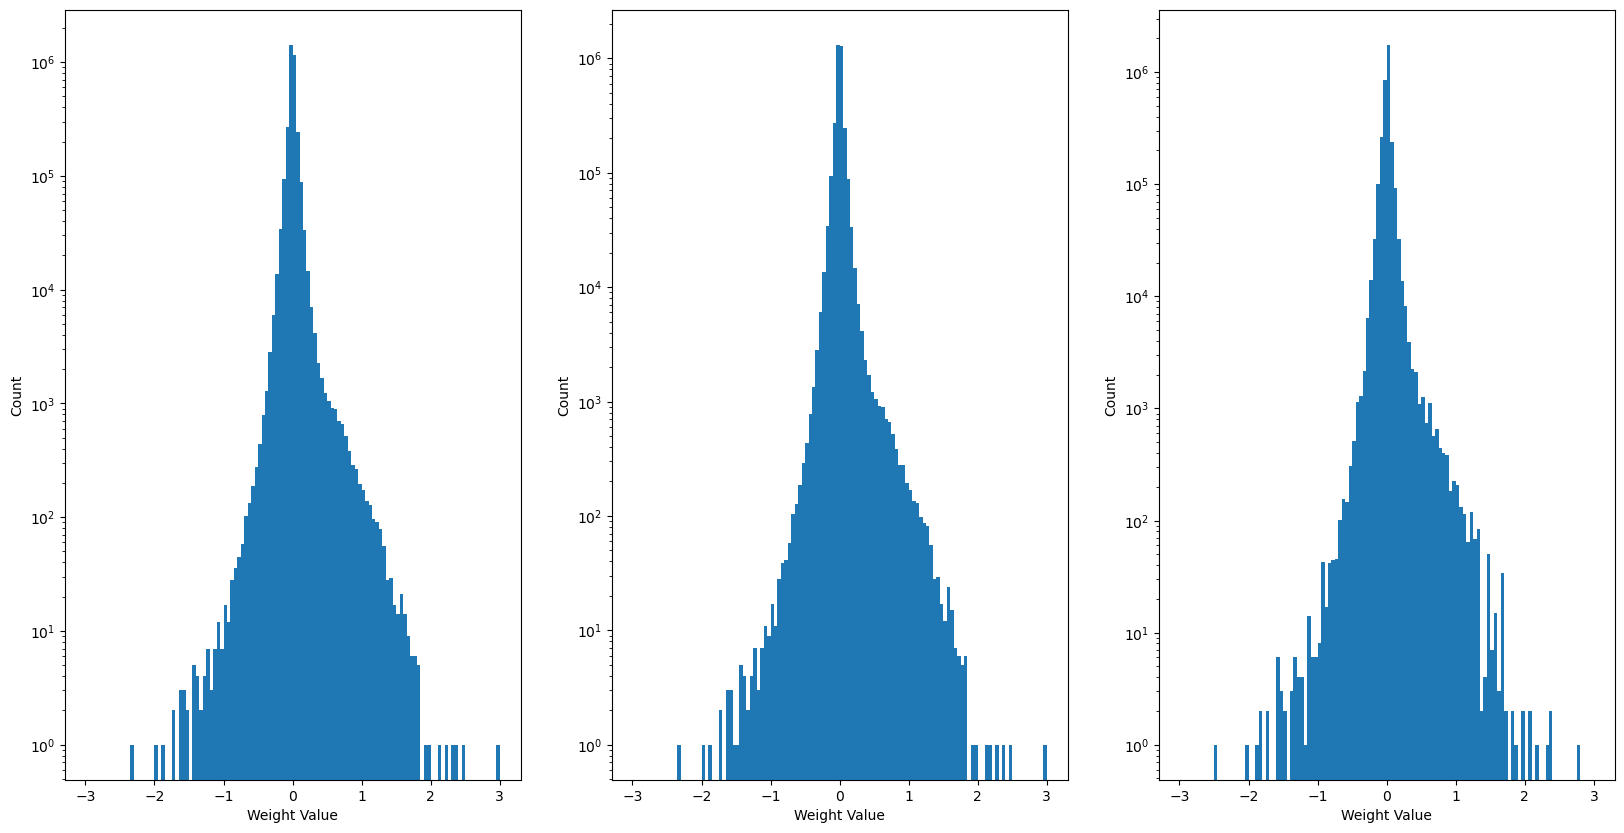

In [9]:
# Visualize weights of the model
fig, ax = plt.subplots(1,3, figsize=(20, 10))
for i, model in enumerate(models_quant):
    weights = []
    for name, param in model.named_parameters():
        if "weight" in name:
            param = param.detach()                
            weights.append(param.numpy().flatten())
        
    weights = np.concatenate(weights)
    
    counts, bins = np.histogram(weights, bins=np.arange(-3, 3.05, 0.05))
    ax[i].hist(bins[:-1], bins, weights=counts)
    ax[i].set_yscale('log')

    # Set labels and title
    ax[i].set_xlabel('Weight Value')
    ax[i].set_ylabel('Count')

# Show the plot
plt.show()

In [13]:
# Calculate precision recall
import time

for i, model in enumerate(models_quant):
    size = quantization[i]
    print(f"Now showing results for {size} quant model")
    start = time.time()
    precision, recall = calculate_performance(model, test_loader)
    end = time.time()
    print("Precision:", precision, "Recall:", recall, "Time:", end-start)
    print("")

Now showing results for 32 quant model
Precision: 0.36016655100624567 Recall: 0.001084655365909219 Time: 67.2544367313385

Now showing results for 8 quant model
Precision: 0.374633431085044 Recall: 0.001065291308181896 Time: 66.95432758331299

Now showing results for 4 quant model
Precision: 0.11524315488353086 Recall: 0.0011904334739761533 Time: 65.03934359550476



In [ ]:
# Quantization to 8 bits keeps the same qualitative results
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

n = 5
i = 0
data_iter = iter(test_loader)
while i < n:
    image, target = next(data_iter)
    fig, ax = plt.subplots(1)
    ax.imshow(np.transpose(image[0].numpy(), (1, 2, 0)) / 255.0)

    for box in target[0]["boxes"]:
        xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        rectangle = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rectangle)

    prediction = models_quant[1](image)

    for box, score, label in zip(prediction[0]["boxes"], prediction[0]["scores"], prediction[0]["labels"]):
        box = box.detach().numpy()
        score = score.detach().numpy()
        label = label.detach().numpy()
        if score >= 0.1 and label == 1:
            xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
            rectangle = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rectangle)

    plt.axis('off')  # Turn off axis labels
    plt.show()
    i += 1